# What is the likelihood of a gap?

Our goal is to develop a statistical model the tells us, for a given vessel, the chance that the satellites will fail to receive a message in a given period of time because the density of vessels in the surrounding area is too high. We will then look for the very unlikely gaps and classify these as events that were likely due to the AIS being shut off.

This notebook focuses on finding the relationship between density of vessels and the number of positions the satellite sees from a given vessel.

### **A few challenges:**
- The odds will change depending on the number of satellites in the sky, and how well the satellites are operating. Thus we'll have to modify the model as more satellites are launched.
- Satellites don't cover the globe uniformly. They will spend more time at different latitudes, meaning that there is likely going to be a function of latitude in this equation.
- Some vessels appear to have weak AIS signals. It would be useful to identify the poorly operating devices.
- AIS devices broadcast more frequently if a vessel is moving more quickly or changing its course. This has to be accounted for somehow.
- There are probably other weird stuff going on too, such as the satellites more easily downloading data in some parts of the world than others.
- We are using Orbcomm data, which isn't as good as ExactEarth. Also, ExactEarth satellites are supposedly much better at this interference problem, meaning that the best strategy is probably just to wait until we have ExactEarth data.

### **Initial Assumptions about AIS Interference**
We assume that at a given time T, the satellite can hear S signals, each vessel broadcasts one signal, and there are N other vessels in the area. Then the chance that your vessels' signal will not interfere with any other vessels is ((C-1)/C)^N. For instance, if N=1, and there are 500 channels, then the odds are 499/500 that your signal will go through -- only one out of every 500 times will your signal and another vessel's overlap. (AIS is, I think, smart about not broadcasting at the same time when the vessels are in line of sight with each other -- about 100km radius -- but the satellites see an area of the earth ~1500km radius, so we can approximate that the vessels can't see each other.) 

So, the odds that you'll be heard in a given time T are proportional to ((C-1)/C)^N, which is the same as (1-1/C)^N.

If the satellite stayed direclty overhead, you'd see that positions/day = K (1-1/C)^N, where K is some constant, N is the number of vessels in the footprint of the satellite. *But*, the satellites move. And you can't just average the number of vessels -- you have to average this function.

Sometimes the vessel you care about will be at the corner of the satellite's radius, and sometimes the satellite will be directly above the vessel. The total number of vessels seen by the satellite (N) could be very different in those two cases, and you can't just average them. So, we need to calculate the number of vessels the satellite sees at every position of its orbit, and how frequently the satellite is in each position, and which positions the satellite can see a given vessel. For simplicity, let's say the satellite visits every lat and lon equally (later we can correct for latitude). 

So, for each lat and lon, we calculate N, the number of vessels within the satellite radius.
Then, for each lat and lon, we calculate (1-1/C)^n, and average this across the satellite radius (to get every position of the satellite that will see the vessels.



### **The Frequency of AIS Brodcast**

The movement of the vessel affects how frequently it will try to broadcast its location. Based on http://www.milltechmarine.com/faq.htm:

Class A:
 Ships Dynamic Conditions        | Dual Channel Receiver | Single Channel Receiver  
 Ship at anchor or moored        | 3 min                 | 6 min                    
 SOG 0-14 knots                  | 10 sec                | 20 sec                   
 SOG 0-14 knots, changing course | 3.3 sec               | 6.6 sec                  
 SOG 14-23 knots                 | 6 sec                 | 12 sec                   
 SOG 14-23 knots, changing course| 2 sec                 | 4 sec                    
 SOG >23 knots                   | 2 sec                 | 4 sec                    
 Ship Static Information         | 6 min                 | 12 min                  

Class B:    
Ships Dynamic Conditions        | Dual Channel Receiver | Single Channel Receiver
SOG < 2 knots                   | 3 min                 | 6 min                   
SOG > 2 knots                   | 10 sec                | 20 sec                   
Ship Static Information         | 6 min                 | 12 min     

Message Types
Class A: 1,2,3
Class B: 18,19


**For a first cut, we will analyze the positions of a vessel that never goes slower than 2 knots if it is Class B, or is never 0 knots if it is Class A, as these messages are supposed to be ~20 to ~60 times less frequent. Otherwise we'll ignore the effects of speed and course changes on positions.** 


In [7]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import colors,colorbar
%matplotlib inline
import csv 
import math
from math import radians, cos, sin, asin, sqrt
from scipy import stats
import math
import cPickle 

In [6]:
def make_map(raster,title=None, colorbar_label=None, maximum=100, 
             minimum=1, scale_type ="log",cutoff=0,savefig=0, 
             png="temp.png", continent_color = '#111111' ):
    plt.clf()
    plt.rcParams["figure.figsize"] = [12,7]
    firstlat = 90-cutoff
    lastlat = -90+cutoff
    firstlon = -180
    lastlon = 180
    scale = cellsize
    truncated_grid = raster[cutoff/cellsize:(180/cellsize)-cutoff/cellsize][:]

    numlats = int((firstlat-lastlat)/scale+.5)
    numlons = int((lastlon-firstlon)/scale+.5)
    lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
    lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)
    fig = plt.figure()
    m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
              llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)
    m.drawmapboundary(fill_color='#111111')
    # m.drawcoastlines(linewidth=.2)
    m.fillcontinents(continent_color,lake_color=continent_color)#, lake_color, ax, zorder, alpha)
    x = np.linspace(-180, 180, 360/cellsize)
    y = np.linspace(lastlat, firstlat, (firstlat-lastlat)/cellsize)
    x, y = np.meshgrid(x, y)
    converted_x, converted_y = m(x, y)
    from matplotlib import colors,colorbar
    if scale_type == 'log':
        norm = colors.LogNorm(vmin=minimum, vmax=maximum)
    else:
        norm = colors.Normalize(vmin=minimum, vmax=maximum)

    m.pcolormesh(converted_x, converted_y, truncated_grid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))
    if title == None:
        title = "A Raster of Some Sorts"
    plt.title(title, color = "#000000", fontsize=18)

    ax = fig.add_axes([0.2, 0.1, 0.4, 0.02]) 
    if scale_type == "log":
        lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
        cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))
        the_labels = []
        for l in lvls:
            if l>=1:
                l = int(l)
            the_labels.append(l)
        cb.ax.set_xticklabels(the_labels, fontsize=10, color = "#000000")
    else:
        cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', cmap = plt.get_cmap('viridis'))
        
    cb.set_label(colorbar_label,labelpad=-40, y=0.45, color = "#000000")
    ax.text(1.7, -0.5, 'Data Source: Orbcomm\nMap by Global Fishing Watch',
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes, color='#000000', fontsize=6)
    if savefig:
        plt.savefig(png,bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1, facecolor="#000000")
    plt.show()

In [2]:
# this is the query that created the positions for each day

''' 
SELECT
  integer(FLOOR(first_lat*10)) lat_bin,
  integer(FLOOR(first_lon*10)) lon_bin,
  integer(FLOOR(avg_lat*10)) lat_bin_avg,
  integer(FLOOR(avg_lon*10)) lon_bin_avg,
  satellite_positions sat_positions,
  terrestrial_positions terrestrial_positions,
  positions_weighted,
  avg_speed,
  slow_pings,
  mmsi
FROM
(SELECT
  mmsi,
  SUM( CASE WHEN speed = 0 OR (speed<=2 AND type IN (18, 19)) THEN 180 
     WHEN (speed > 0 AND speed <14 AND type IN (1,2,3)AND turn = 0 )
         OR (speed>2 AND type IN (18,19)) THEN 10 
      when speed>0 and speed<14 and type in (1,2,3) and turn !=0 then 3.3
      when speed>=14 and speed<23 and type in (1,2,3) and turn = 0 then 6
      when type in (1,2,3) and (speed>=23 or (speed>=14 and turn !=0)) then 2
      END) positions_weighted,
   first(lat) first_lat,
   first(lon) first_lon,
   avg(lat) avg_lat,
   avg(lon) avg_lon,
   max(lat) max_lat,
   min(lat) min_lat,
   max(lon) max_lon,
   min(lon) min_lon,
   avg(speed) avg_speed,
   sum(if( (speed=0 and type in (1,2,3)) or (speed<2 and type in (18,19)),1,0 )) slow_pings,
   sum( if(REGEXP_REPLACE(tagblock_station, 'u', '') IN ('rORBCOMM000',
        'rORBCOMM01',
        'rORBCOMM008',
        'rORBCOMM009',
        'rORBCOMM010'),1,0)) terrestrial_positions,
   sum( if(REGEXP_REPLACE(tagblock_station, 'u', '') not IN ('rORBCOMM000',
        'rORBCOMM01',
        'rORBCOMM008',
        'rORBCOMM009',
        'rORBCOMM010'),1,0)) satellite_positions,       
FROM
  [pipeline_normalize.20150103]
WHERE
  type IN (1,2,3,18,19) and lat is not null and lon is not null and speed is not null and turn is not null
group by mmsi
)
  where
  max_lat - min_lat <5
  AND (max_lon - min_lon < 10
    OR first_lon > 170
    OR first_lon < -170)
  AND mmsi IN (select mmsi from
[scratch_david_gapanalysis.good_mmsi_2015_1000pings])
'''
pass

In [8]:
positions = cPickle.load(open('../../data/density/20150101_v2_vessels.p', 'rb'))

In [9]:
# first calculate a raster of vessel locations from the query
cellsize = 5
num_lons = 360/cellsize
num_lats = 180/cellsize

vessels = np.zeros(shape=(num_lats,num_lons)) 
for row in positions:
    lat = int(row[0])
    lon = int(row[1])
    if lat<900 and lat>-900 and lon>-1800 and lon<1800:
        lat_index = (lat+900)/(cellsize*10)
        lon_index = (lon+1800)/(cellsize*10)
        vessels[lat_index][lon_index] += 1 # one vessel 

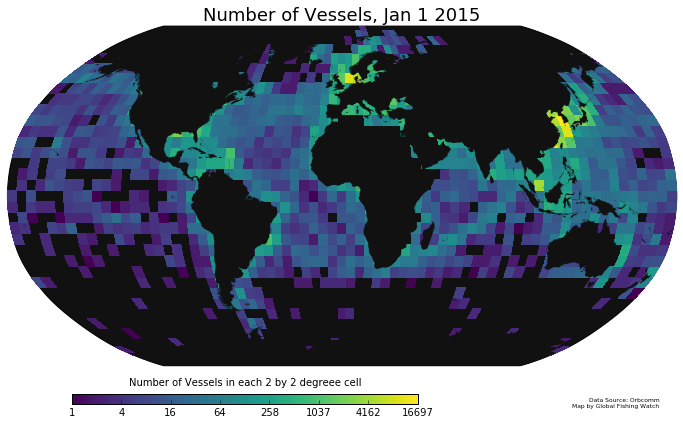

In [10]:
make_map(vessels,title="Number of Vessels, Jan 1 2015",
             colorbar_label="Number of Vessels in each 5 by 5 degreee cell", maximum=vessels.max(), minimum=1)

In [17]:
# what are the actual positions per day?
actual_positions = np.zeros(shape=(num_lats,num_lons))
number_of_vessels = np.zeros(shape=(num_lats,num_lons))

for row in positions:
    lat = int(row[2])
    lon_ave = int(row[3])
    lon_f = int(row[1])
    if abs(lon_f - lon_ave > 50): # use average, except near the dateline
        lon = lon_f
    else:
        lon = lon_ave
    sat_pos = int(row[4])
    all_pos = int(row[5])+int(row[4])
    speed = float(row[7])
    slow_pos = int(row[8])
    # must only be satellite positions
    if sat_pos == all_pos and lat<900 and lat>-900 and lon>-1800 and lon<1800 and speed>2 and slow_pos == 0:
    # and abs(lat)<300:
        lat_index = (lat+900)/(cellsize*10)
        lon_index = (lon+1800)/(cellsize*10)
        actual_positions[lat_index][lon_index] += sat_pos
        number_of_vessels[lat_index][lon_index] += 1
        
for i in range(num_lats):
    for j in range(num_lons):
        if number_of_vessels[i][j]:
            actual_positions[i][j] = float(actual_positions[i][j])/number_of_vessels[i][j]



In [19]:
actual_positions.max()

308.0

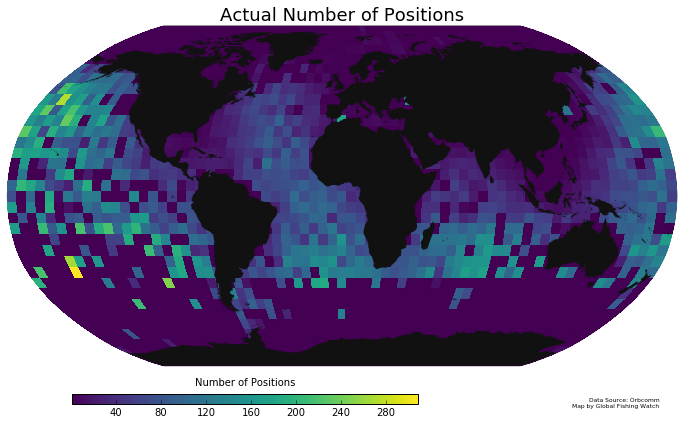

In [20]:
make_map(actual_positions, title="Actual Number of Positions",scale_type="linear",
             colorbar_label="Number of Positions", maximum=actual_positions.max(), minimum=1)

0.68226855858 0.00896366750821 11.7998501373 1.1277801328


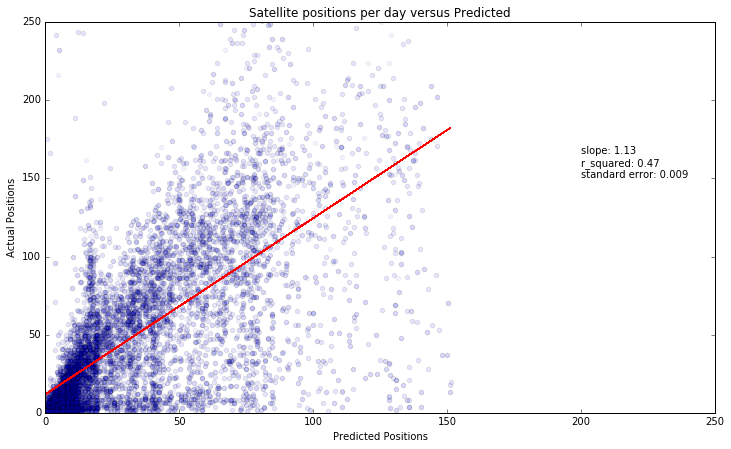

In [38]:
# Plot the relationship for all vessels

den = []
pos = []
predicted_pos = []
pos_weighted = []

for row in positions:
    lat = int(row[2])
    lon_ave = int(row[3])
    lon_f = int(row[1])
    if abs(lon_f - lon_ave > 50): # use average, except near the dateline
        lon = lon_f
    else:
        lon = lon_ave
    sat_pos = int(row[4])
    all_pos = int(row[5])+int(row[4])
    speed = float(row[7])
    slow_pos = int(row[8])
    # must only be satellite positions, with a resaonable position, and not be stopped at all during the day
    if sat_pos == all_pos and lat<900 and lat>-900 and lon>-1800 and lon<1800 and speed>2 and slow_pos == 0:
        lat_index = (lat+900)/(cellsize*10)
        lon_index = (lon+1800)/(cellsize*10)
        den.append(sat_footprints[lat_index][lon_index])
        predicted_pos.append(estimated_positions[lat_index][lon_index])
        pos_weighted.append(float(row[6]))
        pos.append(sat_pos)


fig = plt.figure()
plt.rcParams["figure.figsize"] = [12,7]

ax = fig.add_subplot(1,1,1)
plt.scatter(predicted_pos, pos,  alpha=.05)
slope, intercept, r_value, p_value, std_err = stats.linregress(predicted_pos,pos)
print r_value, std_err, intercept, slope
y = [slope*x + intercept for x in predicted_pos]

plt.plot(predicted_pos,y, "r")
plt.title("Satellite positions per day versus Predicted")
plt.xlabel('Predicted Positions')
plt.ylabel('Actual Positions')
plt.xlim([0,250])
plt.ylim([0,250])
thetext = "slope: "+ str(round(slope,2))+"\nr_squared: "+str(round(r_value**2,2))+"\nstandard error: "+str(round(std_err,3))
ax.text(200, 150, thetext, fontsize=10)
plt.show()